In [1]:
import pandas as pd
df = pd.read_csv(r"D:\MAIN PROJECT PHASE 2\DATASETS\fiqa-2018\train.csv")
print(df['label'].value_counts())


label
0    632
2    295
1     34
Name: count, dtype: int64


In [2]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

labels = df['label'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print("Class weights:", class_weights)


Class weights: tensor([0.5069, 9.4216, 1.0859])


In [1]:
import os
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import pandas as pd
import numpy as np
import string
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error

# ✅ Set paths
model_path = r"D:\MAIN PROJECT PHASE 2\finbert"
dataset_path = r"D:\MAIN PROJECT PHASE 2\DATASETS\fiqa-2018\train.csv"
save_dir = r"D:\MAIN PROJECT PHASE 2\DATASETS\finbert_weights_balanced_ver1"

print("[INFO] Loading tokenizer...")
tokenizer = BertTokenizer.from_pretrained(model_path)

print("[INFO] Loading dataset from CSV...")
df = pd.read_csv(dataset_path)
print(f"[INFO] Dataset loaded with {len(df)} rows")

# ✅ Preprocess function
def preprocess(row):
    sentence = row['sentence'].lower().translate(str.maketrans('', '', string.punctuation))
    snippet = row['snippets'].lower().translate(str.maketrans('', '', string.punctuation))
    text = sentence + " " + snippet
    encoding = tokenizer(text, truncation=True, padding='max_length', max_length=256)
    encoding['labels'] = int(row['label'])  # classification label
    encoding['regression_label'] = float(row['sentiment_score'])  # sentiment score
    return encoding

# ✅ Tokenize dataset
print("[INFO] Tokenizing and encoding dataset...")
dataset = Dataset.from_pandas(df).map(preprocess)
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels', 'regression_label'])
print("[INFO] Tokenization complete")

# ✅ Class weights
class_weights = torch.tensor([0.5069, 9.4216, 1.0859], dtype=torch.float)

# ✅ Define custom model with two heads
class BertMultiTask(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.regressor = nn.Linear(config.hidden_size, 1)
        self.class_weights = class_weights  # added class weights
        self.init_weights()

    def forward(self, input_ids, attention_mask=None, labels=None, regression_label=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)

        class_logits = self.classifier(pooled_output)
        reg_output = self.regressor(pooled_output).squeeze(-1)

        loss = None
        if labels is not None and regression_label is not None:
            loss_fct_class = nn.CrossEntropyLoss(weight=self.class_weights.to(labels.device))
            loss_fct_reg = nn.MSELoss()
            loss_class = loss_fct_class(class_logits, labels)
            loss_reg = loss_fct_reg(reg_output, regression_label)
            loss = loss_class + loss_reg

        return {
            "loss": loss,
            "logits": class_logits,
            "regression": reg_output
        }

# ✅ Load config and model
print("[INFO] Loading model config and base model...")
config = BertConfig.from_pretrained(model_path, num_labels=3)
model = BertMultiTask.from_pretrained(model_path, config=config)
print("[INFO] Model loaded")

# ✅ Define metrics function
def compute_metrics(eval_pred):
    logits, regression_preds = eval_pred.predictions
    labels, reg_true = eval_pred.label_ids
    pred_labels = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, pred_labels),
        "f1": f1_score(labels, pred_labels, average='weighted'),
        "mse": mean_squared_error(reg_true, regression_preds),
    }

# ✅ Define custom trainer with class weights
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        reg_labels = inputs.get("regression_label")
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            labels=labels,
            regression_label=reg_labels
        )
        loss = outputs["loss"]
        return (loss, outputs) if return_outputs else loss


# ✅ Training arguments
training_args = TrainingArguments(
    output_dir=save_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    logging_dir=os.path.join(save_dir, "logs"),
    load_best_model_at_end=True,
    save_total_limit=1,
)

# ✅ Initialize trainer
print("[INFO] Initializing Trainer...")
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=dataset,
    compute_metrics=compute_metrics,
)

# ✅ Train model
print("[INFO] Starting training...")
trainer.train()

# ✅ Save model and tokenizer
print(f"[INFO] Saving fine-tuned model to {save_dir}")
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)
print("[✅ DONE] Model and tokenizer saved to finbert_weights_balanced")



[INFO] Loading tokenizer...
[INFO] Loading dataset from CSV...
[INFO] Dataset loaded with 961 rows
[INFO] Tokenizing and encoding dataset...


Map:   0%|          | 0/961 [00:00<?, ? examples/s]

[INFO] Tokenization complete
[INFO] Loading model config and base model...


Some weights of BertMultiTask were not initialized from the model checkpoint at D:\MAIN PROJECT PHASE 2\finbert and are newly initialized: ['regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\thirishaa\AppData\Roaming\Python\Python311\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


[INFO] Model loaded
[INFO] Initializing Trainer...
[INFO] Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Mse
1,No log,0.656865,0.898023,0.883815,0.064312
2,No log,0.422520,0.946930,0.939104,0.029493
3,No log,0.239547,0.979188,0.978703,0.025402


[INFO] Saving fine-tuned model to D:\MAIN PROJECT PHASE 2\DATASETS\finbert_weights_balanced_ver1
[✅ DONE] Model and tokenizer saved to finbert_weights_balanced


Map:   0%|          | 0/102 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]


📊 Sentiment Label Classification - Validation Set
Accuracy: 0.824
Weighted F1 Score: 0.810
Classification Report:
               precision    recall  f1-score   support

    positive       0.84      0.94      0.89        34
     neutral       1.00      0.53      0.69        34
    negative       0.74      1.00      0.85        34

    accuracy                           0.82       102
   macro avg       0.86      0.82      0.81       102
weighted avg       0.86      0.82      0.81       102



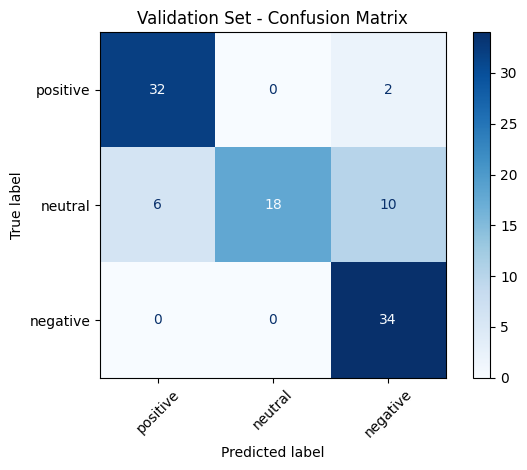


📈 Sentiment Score Regression - Validation Set
Index True Score     Predicted Score
0     0.2420         0.3321         
1     0.0370         -0.2251        
2     -0.3190        -0.3928        
3     -0.3420        -0.4508        
4     0.3650         0.4628         
5     0.0530         0.3263         
6     -0.5300        -0.5524        
7     0.0770         -0.2541        
8     0.0000         0.2114         
9     0.3660         0.4071         
10    -0.0090        -0.0909        
11    0.2340         0.0980         
12    0.5730         0.4324         
13    -0.0520        -0.2990        
14    0.0540         -0.1864        
15    0.3260         0.3337         
16    -0.5320        -0.5216        
17    -0.2660        -0.4980        
18    -0.4390        -0.5405        
19    0.6030         0.3904         
20    -0.3910        -0.4363        
21    0.0160         -0.1681        
22    -0.2870        -0.4587        
23    0.4650         0.4251         
24    0.0660         -0.3396

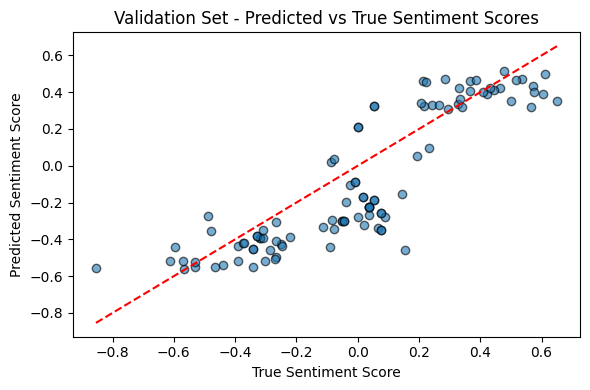


📊 Sentiment Label Classification - Test Set
Accuracy: 0.667
Weighted F1 Score: 0.617
Classification Report:
               precision    recall  f1-score   support

    positive       0.62      0.90      0.74        50
     neutral       0.92      0.22      0.35        50
    negative       0.67      0.88      0.76        50

    accuracy                           0.67       150
   macro avg       0.74      0.67      0.62       150
weighted avg       0.74      0.67      0.62       150



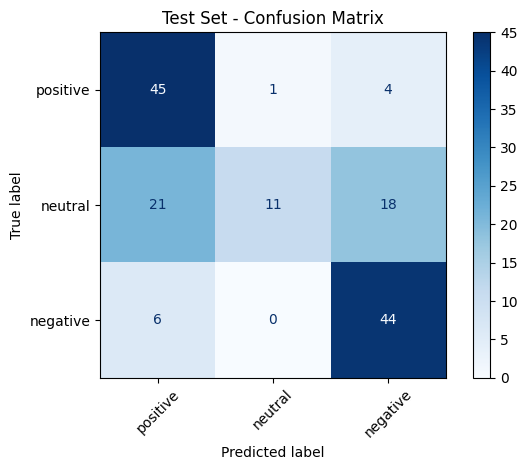


📈 Sentiment Score Regression - Test Set
Index True Score     Predicted Score
0     0.5200         0.3688         
1     -0.4430        -0.2644        
2     0.2360         0.0752         
3     -0.3070        -0.4359        
4     0.2820         0.1830         
5     -0.2210        -0.3246        
6     -0.2990        0.3500         
7     0.3620         0.3169         
8     -0.3470        -0.2655        
9     0.4840         0.4177         
10    -0.0430        -0.2353        
11    -0.3080        -0.5263        
12    -0.0460        0.3550         
13    0.7210         0.3982         
14    0.0000         -0.3490        
15    0.2520         0.3006         
16    -0.0700        -0.4516        
17    0.2450         0.2562         
18    -0.0450        0.0952         
19    0.5160         0.3661         
20    0.3640         0.1576         
21    -0.1000        -0.5060        
22    0.4310         0.3634         
23    0.0000         -0.3408        
24    0.4920         0.3760       

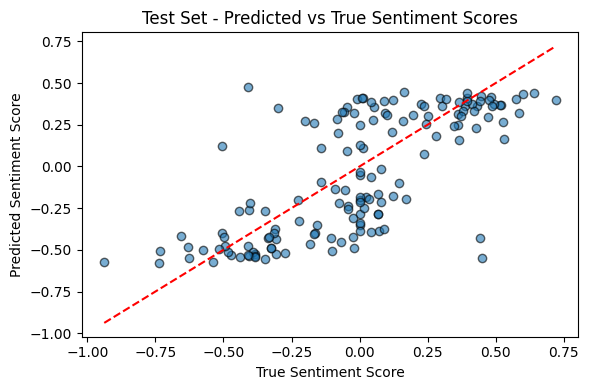

In [1]:
import torch
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizer, BertPreTrainedModel, BertModel, BertConfig
from torch import nn
from sklearn.metrics import accuracy_score, f1_score, classification_report, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ✅ Multi-task model class definition
class BertMultiTask(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, 3)
        self.regressor = nn.Linear(config.hidden_size, 1)
        self.init_weights()

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        score = self.regressor(pooled_output).squeeze(-1)
        return logits, score

# ✅ Paths
model_path = r"D:\MAIN PROJECT PHASE 2\DATASETS\finbert_weights_balanced_ver1"
test_csv = r"D:\MAIN PROJECT PHASE 2\DATASETS\fiqa-2018\test.csv"
val_csv = r"D:\MAIN PROJECT PHASE 2\DATASETS\fiqa-2018\validation.csv"

# ✅ Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained(model_path)
config = BertConfig.from_pretrained(model_path)
model = BertMultiTask.from_pretrained(model_path, config=config)
model.eval()

# ✅ Preprocess function
def preprocess(row):
    text = row['sentence'].lower() + " " + row['snippets'].lower()
    encoding = tokenizer(text, truncation=True, padding='max_length', max_length=256)
    encoding['label'] = int(row['label'])
    encoding['score'] = float(row['sentiment_score'])
    return encoding

# ✅ Load datasets
def load_data(path):
    df = pd.read_csv(path)
    dataset = Dataset.from_pandas(df).map(preprocess)
    dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label", "score"])
    return dataset

val_data = load_data(val_csv)
test_data = load_data(test_csv)

label_list = ['positive', 'neutral', 'negative']

# ✅ Classification Evaluation
def evaluate_classification(dataset, name="Dataset"):
    preds_cls = []
    true_cls = []

    for batch in dataset:
        input_ids = batch['input_ids'].unsqueeze(0)
        attention_mask = batch['attention_mask'].unsqueeze(0)

        with torch.no_grad():
            logits, _ = model(input_ids=input_ids, attention_mask=attention_mask)
            pred_label = torch.argmax(logits, dim=1).item()

        preds_cls.append(pred_label)
        true_cls.append(batch['label'])

    acc = accuracy_score(true_cls, preds_cls)
    f1 = f1_score(true_cls, preds_cls, average='weighted')
    report = classification_report(true_cls, preds_cls, target_names=label_list, zero_division=0)
    cm = confusion_matrix(true_cls, preds_cls)

    print(f"\n📊 Sentiment Label Classification - {name}")
    print(f"Accuracy: {acc:.3f}")
    print(f"Weighted F1 Score: {f1:.3f}")
    print("Classification Report:\n", report)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"{name} - Confusion Matrix")
    plt.tight_layout()
    plt.show()

# ✅ Regression Evaluation
def evaluate_regression(dataset, name="Dataset"):
    preds_score = []
    true_score = []

    print(f"\n📈 Sentiment Score Regression - {name}")
    print(f"{'Index':<6}{'True Score':<15}{'Predicted Score':<15}")

    for i, batch in enumerate(dataset):
        input_ids = batch['input_ids'].unsqueeze(0)
        attention_mask = batch['attention_mask'].unsqueeze(0)

        with torch.no_grad():
            _, score = model(input_ids=input_ids, attention_mask=attention_mask)

        predicted = score.item()
        actual = batch['score']

        preds_score.append(predicted)
        true_score.append(actual)

        print(f"{i:<6}{actual:<15.4f}{predicted:<15.4f}")

    mse = mean_squared_error(true_score, preds_score)

    print(f"\n✅ MSE (Mean Squared Error): {mse:.5f}")

    plt.figure(figsize=(6, 4))
    plt.scatter(true_score, preds_score, alpha=0.6, edgecolors='k')
    plt.plot([min(true_score), max(true_score)], [min(true_score), max(true_score)], 'r--')
    plt.xlabel("True Sentiment Score")
    plt.ylabel("Predicted Sentiment Score")
    plt.title(f"{name} - Predicted vs True Sentiment Scores")
    plt.tight_layout()
    plt.show()

# ✅ Run evaluations
evaluate_classification(val_data, name="Validation Set")
evaluate_regression(val_data, name="Validation Set")

evaluate_classification(test_data, name="Test Set")
evaluate_regression(test_data, name="Test Set")


In [7]:
import os
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import pandas as pd
import numpy as np
import string
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error

# ✅ Set paths
model_path = r"D:\MAIN PROJECT PHASE 2\finbert"
dataset_path = r"D:\MAIN PROJECT PHASE 2\DATASETS\fiqa-2018\train.csv"
save_dir = r"D:\MAIN PROJECT PHASE 2\DATASETS\finbert_weights_balanced"

print("[INFO] Loading tokenizer...")
tokenizer = BertTokenizer.from_pretrained(model_path)

print("[INFO] Loading dataset from CSV...")
df = pd.read_csv(dataset_path)
print(f"[INFO] Dataset loaded with {len(df)} rows")

# ✅ Preprocess function
def preprocess(row):
    sentence = row['sentence'].lower().translate(str.maketrans('', '', string.punctuation))
    snippet = row['snippets'].lower().translate(str.maketrans('', '', string.punctuation))
    text = sentence + " " + snippet
    encoding = tokenizer(text, truncation=True, padding='max_length', max_length=256)
    encoding['labels'] = int(row['label'])  # classification label
    encoding['regression_label'] = float(row['sentiment_score'])  # sentiment score
    return encoding

# ✅ Tokenize dataset
print("[INFO] Tokenizing and encoding dataset...")
dataset = Dataset.from_pandas(df).map(preprocess)
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels', 'regression_label'])
print("[INFO] Tokenization complete")

# ✅ Class weights
class_weights = torch.tensor([0.5069, 9.4216, 1.0859], dtype=torch.float)

# ✅ Define custom model with two heads
class BertMultiTask(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.regressor = nn.Linear(config.hidden_size, 1)
        self.class_weights = class_weights  # added class weights
        self.init_weights()

    def forward(self, input_ids, attention_mask=None, labels=None, regression_label=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)

        class_logits = self.classifier(pooled_output)
        reg_output = self.regressor(pooled_output).squeeze(-1)

        loss = None
        if labels is not None and regression_label is not None:
            loss_fct_class = nn.CrossEntropyLoss(weight=self.class_weights.to(labels.device))
            loss_fct_reg = nn.MSELoss()
            loss_class = loss_fct_class(class_logits, labels)
            loss_reg = loss_fct_reg(reg_output, regression_label)
            loss = loss_class + loss_reg

        return {
            "loss": loss,
            "logits": class_logits,
            "regression": reg_output
        }

# ✅ Load config and model
print("[INFO] Loading model config and base model...")
config = BertConfig.from_pretrained(model_path, num_labels=3)
model = BertMultiTask.from_pretrained(model_path, config=config)
print("[INFO] Model loaded")

# ✅ Define metrics function
def compute_metrics(eval_pred):
    logits, regression_preds = eval_pred.predictions
    labels, reg_true = eval_pred.label_ids
    pred_labels = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, pred_labels),
        "f1": f1_score(labels, pred_labels, average='weighted'),
        "mse": mean_squared_error(reg_true, regression_preds),
    }

# ✅ Define custom trainer with class weights
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        reg_labels = inputs.get("regression_label")
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            labels=labels,
            regression_label=reg_labels
        )
        loss = outputs["loss"]
        return (loss, outputs) if return_outputs else loss


# ✅ Training arguments with hyperparameters tuning
training_args = TrainingArguments(
    output_dir=save_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,  # Change batch size (experiment with 16, 32)
    num_train_epochs=5,              # Experiment with more epochs (e.g., 5, 7, 10)
    logging_dir=os.path.join(save_dir, "logs"),
    load_best_model_at_end=True,
    save_total_limit=1,
    learning_rate=2e-5,              # Adjust learning rate (e.g., 1e-5, 2e-5, 3e-5)
    warmup_steps=500,                # Increase warm-up steps (e.g., 500, 1000)
    weight_decay=0.01,               # You can also try adding weight decay to prevent overfitting
    logging_steps=100,               # Adjust logging frequency
)

# Initialize Trainer with custom arguments
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=dataset,
    compute_metrics=compute_metrics,
)

# ✅ Train model
print("[INFO] Starting training...")
trainer.train()

# ✅ Save model and tokenizer
print(f"[INFO] Saving fine-tuned model to {save_dir}")
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)
print("[✅ DONE] Model and tokenizer saved to finbert_weights_balanced")


[INFO] Loading tokenizer...
[INFO] Loading dataset from CSV...
[INFO] Dataset loaded with 961 rows
[INFO] Tokenizing and encoding dataset...


Map:   0%|          | 0/961 [00:00<?, ? examples/s]

[INFO] Tokenization complete
[INFO] Loading model config and base model...


Some weights of BertMultiTask were not initialized from the model checkpoint at D:\MAIN PROJECT PHASE 2\finbert and are newly initialized: ['regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\thirishaa\AppData\Roaming\Python\Python311\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


[INFO] Model loaded
[INFO] Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Mse
1,No log,1.540618,0.537981,0.588165,0.156842
2,1.779100,0.991334,0.657648,0.680937,0.100634
3,1.779100,0.734260,0.783559,0.797613,0.076806
4,1.031800,0.513239,0.907388,0.905654,0.056685
5,0.750400,0.394357,0.893861,0.908033,0.057664


[INFO] Saving fine-tuned model to D:\MAIN PROJECT PHASE 2\DATASETS\finbert_weights_balanced
[✅ DONE] Model and tokenizer saved to finbert_weights_balanced
